In [3]:
import os
import re
import random
import pandas as pd
import matplotlib.pyplot as plt

from mecab import MeCab
from konlpy.tag import Okt
from collections import Counter

In [4]:
data_path = "../dataset"
test_df = pd.read_csv(f"{data_path}/test.csv")

In [5]:
print("Test DataFrame")
print(test_df.shape)
print(test_df.columns)

Test DataFrame
(499, 2)
Index(['fname', 'dialogue'], dtype='object')


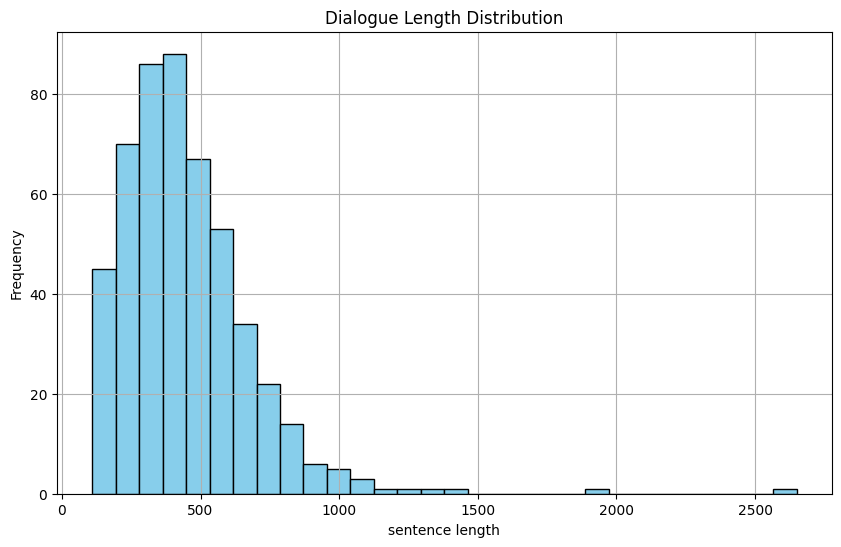

In [6]:
test_df['sentence_length'] = test_df['dialogue'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(test_df['sentence_length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.title('Dialogue Length Distribution')
plt.grid(True)
plt.show()

In [8]:
# min, max, mode 길이를 계산하는 함수 정의
def get_length_stats(column):
    min_length = column.min()
    max_length = column.max()
    mode_length = column.mode()[0]
    return min_length, max_length, mode_length

# dialogue와 summary의 길이에 대한 통계 계산
dialogue_min, dialogue_max, dialogue_mode = get_length_stats(test_df['sentence_length'])

dialogue_stats = {
    'Dialogue': {
        'Min Length': dialogue_min,
        'Max Length': dialogue_max,
        'Mode Length': dialogue_mode
    },
}

print(dialogue_stats)

{'Dialogue': {'Min Length': 109, 'Max Length': 2650, 'Mode Length': 349}}


In [6]:
# 특수 문자열 패턴 찾기 함수
def find_special_strings(text):
    return re.findall(r'#\w+#', text)

test_df['dialogue_special_strings'] = test_df['dialogue'].apply(find_special_strings)
unique_dialogue_strings = set([item for sublist in test_df['dialogue_special_strings'] for item in sublist])

print(unique_dialogue_strings)

{'#Person1#', '#Person2#', '#Person3#', '#Address#', '#PassportNumber#', '#PhoneNumber#'}


In [7]:
## 분석하기 전에 [#문자열#:]을 제거한다.
def remove_speaker_tags(text):
    return re.sub(r'#\w+#:', '', text)

## 개행 문자 제거.
def remove_newlines(text):
    # 개행 문자를 문장부호 뒤에 공백과 함께 추가
    text = re.sub(r'([.?!])\n', r'\1 ', text)

    # 개행 문자가 남아있는 경우 제거
    return text.replace('\n', ' ')

mecab = MeCab()
test_df['cleaned_dialogue'] = test_df['dialogue'].apply(lambda x: remove_newlines(remove_speaker_tags(x)))
test_df['dialogue_morphs'] = test_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))

test_df.head()

,fname,dialogue,sentence_length,dialogue_special_strings,cleaned_dialogue,dialogue_morphs
0,test_0,"#Person1#: 더슨 씨, 받아쓰기 좀 해주세요. \n#Person2#: 네, ...",821,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","더슨 씨, 받아쓰기 좀 해주세요. 네, 실장님... 이것은 오늘 오후까지 모...","[더슨, 씨, ,, 받아쓰, 기, 좀, 해, 주, 세요, ., 네, ,, 실장, 님..."
1,test_1,#Person1#: 드디어 왔네! 왜 그렇게 오래 걸렸어?\n#Person2#: 또...,625,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",드디어 왔네! 왜 그렇게 오래 걸렸어? 또 교통 체증에 걸렸어. 까르푸 교차로에...,"[드디어, 왔, 네, !, 왜, 그렇게, 오래, 걸렸, 어, ?, 또, 교통, 체증..."
2,test_2,"#Person1#: 케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. \n#Per...",481,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. 어떤 말이야? 마샤와 히...","[케이트, ,, 무슨, 일, 이, 일어났, 는지, 너, 는, 믿, 지, 못할, 거,..."
3,test_3,"#Person1#: 생일 축하해, 이건 너를 위한 거야, 브라이언.\n#Person...",388,"[#Person1#, #Person2#, #Person1#, #Person2#, #...","생일 축하해, 이건 너를 위한 거야, 브라이언. 기억해줘서 너무 행복해, 들어와...","[생일, 축하, 해, ,, 이건, 너, 를, 위한, 거, 야, ,, 브라이언, .,..."
4,test_4,#Person1#: 이 올림픽 공원이 정말 크네요!\n#Person2#: 네. 지금...,389,"[#Person1#, #Person2#, #Person1#, #Person2#, #...",이 올림픽 공원이 정말 크네요! 네. 지금 우리는 이 공원의 중심인 올림픽 스타...,"[이, 올림픽, 공원, 이, 정말, 크, 네요, !, 네, ., 지금, 우리, 는,..."


In [11]:
## "ㅋㅋ", "ㅎㅎ"와 같은 구어체에서 벗어나는 형태가 있는지 확인.
def find_special_patterns(morphs):
    consonant_pattern = re.compile(r'^[ㄱ-ㅎ]{2,}$')  # 자음이 최소 2번 이상 반복되는 경우만

    return [morph for morph in morphs if consonant_pattern.match(morph)]

# 형태소 분석
test_df['dialogue_morphs'] = test_df['cleaned_dialogue'].apply(lambda x: mecab.morphs(x))

# 특이 패턴 찾기
test_df['dialogue_special_patterns'] = test_df['dialogue_morphs'].apply(find_special_patterns)
dialogue_special_rows = test_df[test_df['dialogue_special_patterns'].apply(lambda x: len(x) > 0)]
dialogue_special_rows_info = dialogue_special_rows[['dialogue', 'dialogue_special_patterns']].reset_index()

print("Dialogue with Special Patterns:")
print(dialogue_special_rows_info)

Dialogue with Special Patterns:
Empty DataFrame
Columns: [index, dialogue, dialogue_special_patterns]
Index: []


In [12]:
# 반복되는 글자 패턴을 찾는 함수
def find_repeated_patterns(text):
    # 반복되는 글자 패턴을 찾기 위한 정규식 (같은 글자가 3번 이상 반복)
    # repeated_pattern = re.compile(r'(.)\1{2,}')
    repeated_pattern = re.compile(r'([가-힣])\1{2,}')  # 동일한 한글 글자가 연속적으로 2번 이상 반복

    return [match.group(0) for match in repeated_pattern.finditer(text)]

# 반복되는 글자 패턴 찾기
test_df['dialogue_repeated_patterns'] = test_df['cleaned_dialogue'].apply(find_repeated_patterns)

# 반복되는 패턴이 포함된 Dialogue 행 필터링
dialogue_repeated_rows = test_df[test_df['dialogue_repeated_patterns'].apply(lambda x: len(x) > 0)]
dialogue_repeated_rows_info = dialogue_repeated_rows[['dialogue', 'dialogue_repeated_patterns']].reset_index()

print("Dialogue with Repeated Patterns:")
print(dialogue_repeated_rows_info)

Dialogue with Repeated Patterns:
Empty DataFrame
Columns: [index, dialogue, dialogue_repeated_patterns]
Index: []


In [13]:
# 한글이 아닌 다른 문자를 찾는 함수
def find_non_hangul_patterns(text):
    # 한글, 공백, 기본 구두점(.,?!, 공백)을 제외한 모든 문자 또는 연속된 점(...) 패턴을 찾음
    non_hangul_pattern = re.compile(r'[^가-힣\s.,?!]|(?<!\.)\.\.+')
    return non_hangul_pattern.findall(text)

test_df['dialogue_non_hangul_patterns'] = test_df['cleaned_dialogue'].apply(find_non_hangul_patterns)
dialogue_non_hangul_rows_info = test_df[test_df['dialogue_non_hangul_patterns'].apply(lambda x: len(x) > 0)][['dialogue', 'dialogue_non_hangul_patterns']]
print(dialogue_non_hangul_rows_info)

                                              dialogue  \
0    #Person1#: 더슨 씨, 받아쓰기 좀 해주세요. \n#Person2#: 네, ...   
2    #Person1#: 케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. \n#Per...   
4    #Person1#: 이 올림픽 공원이 정말 크네요!\n#Person2#: 네. 지금...   
5    #Person1#: 진짜 짜증나! 이런 회사에서 일하는 건 나에게 아무런 도움이 안...   
7    #Person1#: 잘 오셨습니다. 무엇을 도와드릴까요?\n#Person2#: 저는...   
..                                                 ...   
494  #Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할...   
495  #Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...   
496  #Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻...   
497  #Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...   
498  #Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ...   

                   dialogue_non_hangul_patterns  
0                                 [..., ..., 4]  
2                                           [2]  
4                          [6, 5, 0, 0, 0, ...]  
5                                  [1, G, D, P]  
7    [3, 0, 9, ..., 3, 0, ..., 1, 1, 2, 0, ...]  
.. 

In [14]:
with open('./test-non_kor.txt', 'w', encoding='utf-8') as file:
    for index in range(277):
        patterns = dialogue_non_hangul_rows_info.iloc[index]['dialogue_non_hangul_patterns']
        dialogue = dialogue_non_hangul_rows_info.iloc[index]['dialogue']
        file.write(f"Index {index}:\nPatterns: {patterns}\nDialogue: {dialogue}\n\n")